# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit,
                           plot_distance_weights,
                           plot_sim_results,
                           plot_parameters_kde)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ina_generic import ina as model
model.sample({})

,x,y,exp
0,-90.000000,-5.261781e-06,0
1,-80.000000,-4.893529e-04,0
2,-70.000000,-4.347802e-02,0
3,-60.000000,-3.229473e+00,0
4,-50.000000,-1.252228e+02,0
5,-40.000000,-1.116509e+03,0
6,-30.000000,-2.261101e+03,0
7,-20.000000,-2.303820e+03,0
8,-10.000000,-1.767243e+03,0
9,0.000000,-9.007919e+02,0


# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_Na=(0, 100),
              Vhalf_m=(-100,100),
              k_m=(0,50),
              c_bm=(0,0.1),
              c_am=(0,1),
              Vmax_m=(-100,0),
              sigma_m=(0,50),
              Vhalf_h=(-100,0),
              k_h=(-50,0),
              c_bh=(0,0.1),
              c_ah=(0,50),
              Vmax_h=(-100,0),
              sigma_h=(0,50),
              c_bj=(0,10),
              c_aj=(50,100),
              Vmax_j=(-100,0),
              sigma_j=(0,50))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [8]:
parameters = ['ina.'+k for k in limits.keys()]

In [9]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

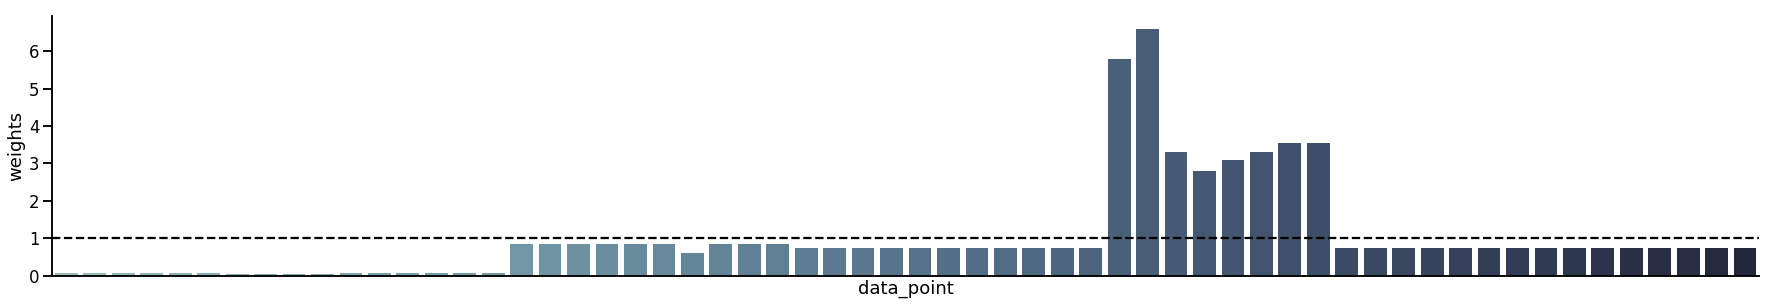

In [10]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)
g.savefig('results/ina-generic/dist_weights.pdf')

In [14]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.05,
    n_samples=1000)

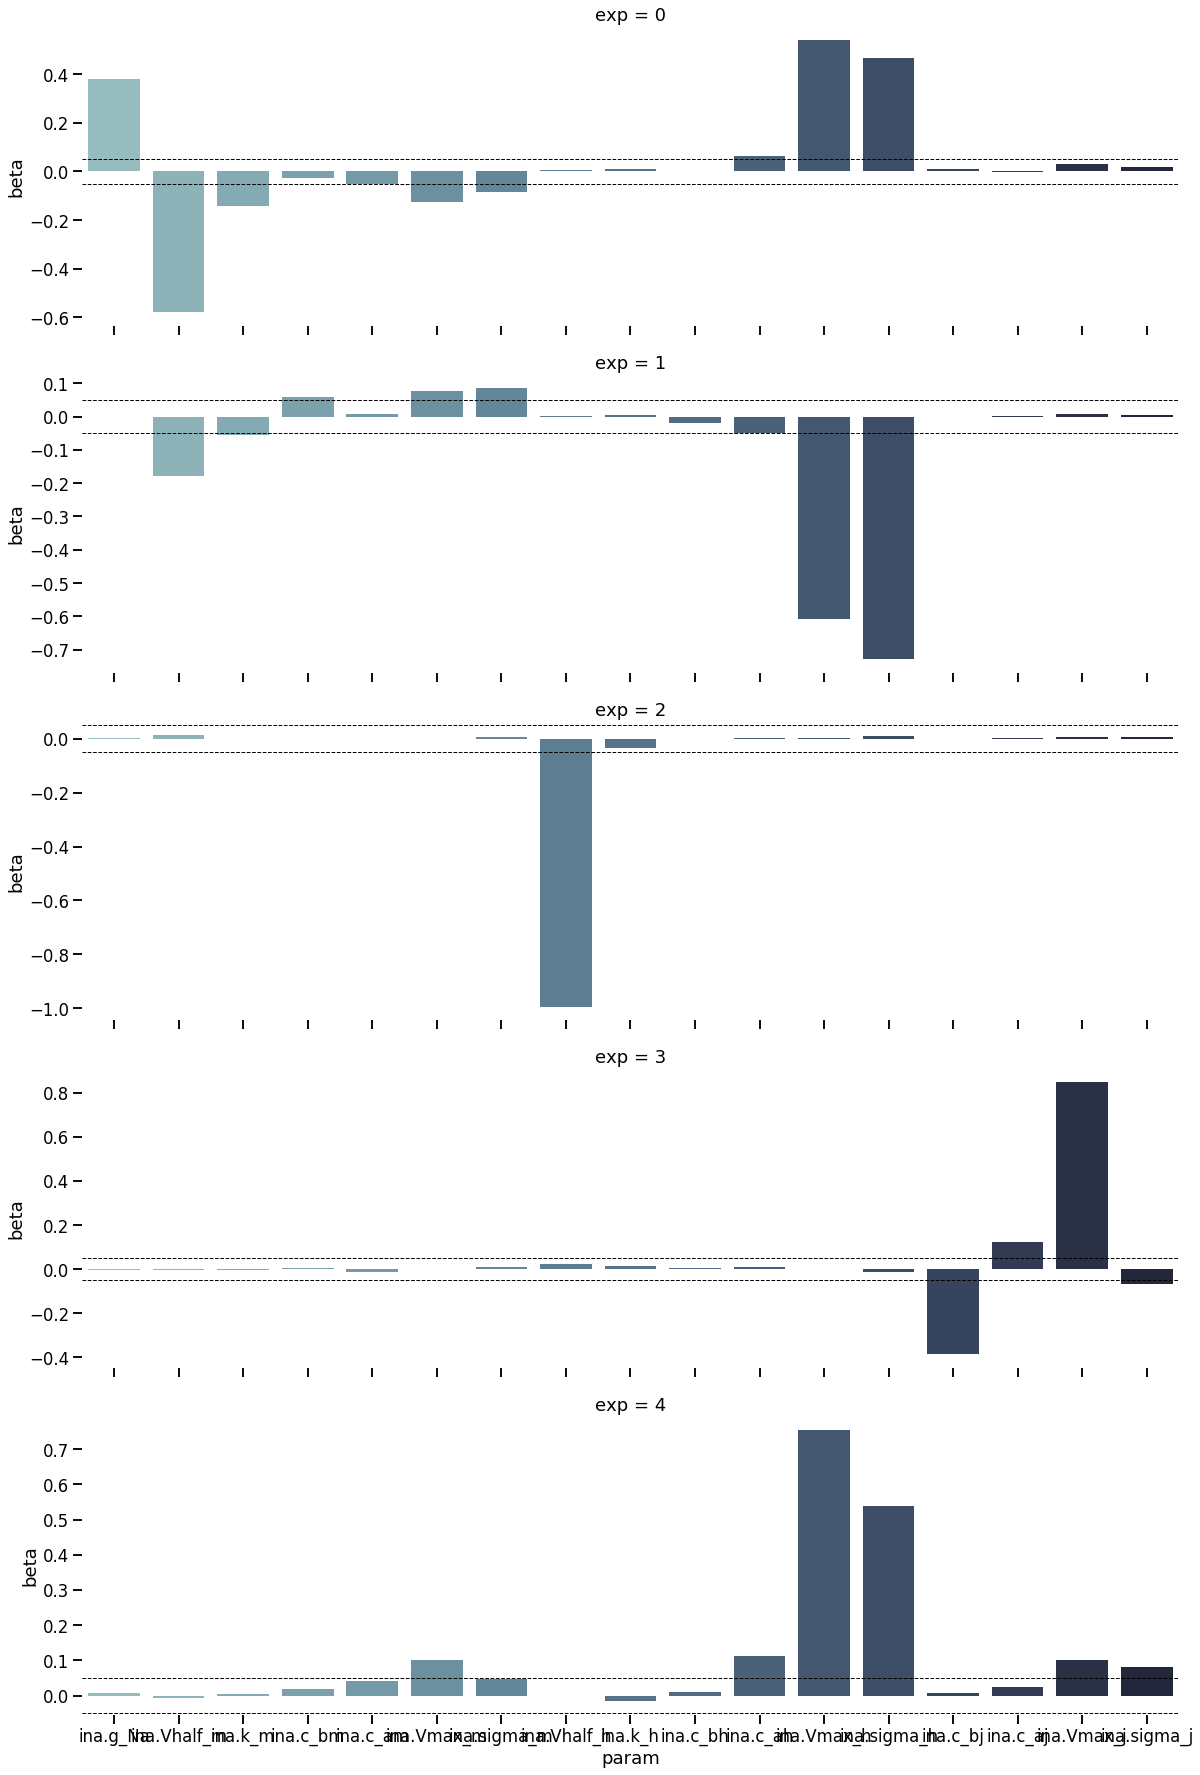

In [15]:
sns.set_context('talk')
grid1 = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

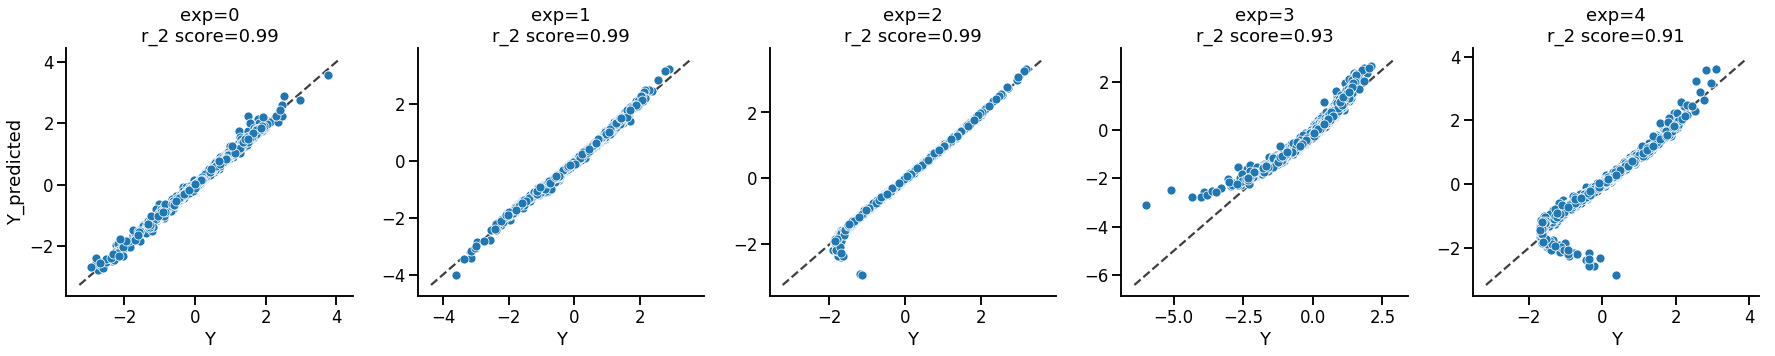

In [16]:
grid2 = plot_regression_fit(regression_fit, r2)

In [17]:
grid1.savefig('results/ina-generic/sensitivity.pdf')
grid2.savefig('results/ina-generic/sensitivity_fit.pdf')

In [32]:
# Finding insensitive parameters
cutoff = 0.05
fitted_pivot = fitted.pivot(index='param',columns='exp')
insensitive_params = fitted_pivot[(abs(fitted_pivot['beta'][0])<cutoff) & (abs(fitted_pivot['beta'][1])<cutoff) &
             (abs(fitted_pivot['beta'][2])<cutoff) & (abs(fitted_pivot['beta'][3])<cutoff) &
             (abs(fitted_pivot['beta'][4])<cutoff)].index.values

In [42]:
insensitive_params

array(['ina.Vmax_h', 'ina.Vmax_m', 'ina.c_ah', 'ina.c_aj', 'ina.c_am',
       'ina.k_h', 'ina.sigma_h', 'ina.sigma_m'], dtype=object)

In [43]:
insensitive_params = np.delete(insensitive_params,5)

In [91]:
insensitive_params

array(['ina.Vmax_h', 'ina.Vmax_m', 'ina.c_ah', 'ina.c_aj', 'ina.c_am',
       'ina.sigma_h', 'ina.sigma_m'], dtype=object)

In [92]:
insensitive_limits = dict((k, limits[k[4:]]) for k in insensitive_params)
insensitive_prior = Distribution(**{key: RV("uniform", a, b - a)
                                 for key, (a,b) in insensitive_limits.items()})

In [93]:
# Generate random samples for insensitive parameters
def generate_sample(insensitive_prior, n):
    samples = [dict() for i in range(n)]
    for i in range(n):
        parameters = insensitive_prior.rvs()
        sample = {key: value for key, value in parameters.items()}
        samples[i].update(sample)
    return samples

In [94]:
samples = generate_sample(insensitive_prior, 1000)

In [95]:
model.add_external_par_samples(samples)

In [96]:
limits = dict((k, limits[k]) for k in limits if 'ina.'+k not in insensitive_params)

In [97]:
limits

{'g_Na': (0, 100),
 'Vhalf_m': (-100, 100),
 'k_m': (0, 50),
 'c_bm': (0, 0.1),
 'Vhalf_h': (-100, 100),
 'k_h': (-50, 0),
 'c_bh': (0, 10),
 'c_bj': (0, 50),
 'Vmax_j': (-500, 500),
 'sigma_j': (0, 500)}

In [9]:
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise pyabc database

In [20]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ina1250.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ina1250.db


In [21]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [22]:
from pyabc.populationstrategy import ConstantPopulationSize

In [23]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(1250),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.05482047444775661, 1: 0.05482047444775661, 2: 0.05482047444775661, 3: 0.05482047444775661, 4: 0.05482047444775661, 5: 0.05482047444775661, 6: 0.04793030963340064, 7: 0.04260405991323703, 8: 0.0479278046958729, 9: 0.0536798519659175, 10: 0.05482047444775661, 11: 0.05482047444775661, 12: 0.05482047444775661, 13: 0.05482047444775661, 14: 0.05482047444775661, 15: 0.05482047444775661, 16: 0.8326197611814873, 17: 0.8326197611814873, 18: 0.8326197611814873, 19: 0.8326197611814873, 20: 0.8326197611814873, 21: 0.8326197611814873, 22: 0.6017669628485173, 23: 0.8326197611814873, 24: 0.8326197611814873, 25: 0.8326197611814873, 26: 0.7463215252566501, 27: 0.7463215252566501, 28: 0.7463215252566501, 29: 0.7463215252566501, 30: 0.7463215252566501, 31: 0.7463215252566501, 32: 0.7463215252566501, 33: 0.7463215252566501, 34: 0.7463215252566501, 35: 0.7463215252566501, 36: 0.7463215252566501, 37: 5.779317930650152, 38: 6.604934777885866, 39: 3.3021281756664393, 40: 2.

In [24]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-11-22 23:27:22.778901, end_time=None)>
INFO:Epsilon:initial epsilon is 18.533647351980473


In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=100, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:18.533647351980473
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2554
DEBUG:Epsilon:new eps, t=1, eps=17.779199062326676
INFO:ABC:t:1 eps:17.779199062326676
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 5631
DEBUG:Epsilon:new eps, t=2, eps=14.120462520206045
INFO:ABC:t:2 eps:14.120462520206045
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 10022
DEBUG:Epsilon:new eps, t=3, eps=12.650471791026256
INFO:ABC:t:3 eps:12.650471791026256
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 14140
DEBUG:Epsilon:new eps, t=4, eps=10.193282853883863
INFO:ABC:t:4 eps:10.193282853883863
DEBUG:ABC:now submitting population 4


# Results analysis

In [26]:
history = [History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/ina-generic/hl-1_ina50.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/ina-generic/hl-1_ina100.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/ina-generic/hl-1_ina500.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/ina-generic/hl-1_ina750.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/ina-generic/hl-1_ina1000.db'),
           History('sqlite:////storage/hhecm/cellrotor/chouston/results/convergence/ina-generic/hl-1_ina1250.db')]
particle_num = [50,100,500,750,1000,1250]#,2000,5000]

In [27]:
n_samples=5000
th_samples = pd.DataFrame({})
for h, p in zip(history, particle_num):
    h.id = len(h.all_runs())
    df, w = h.get_distribution(m=0)
    th = pd.DataFrame(df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records'))
    th['particle_num'] = p
    th_samples = th_samples.append(th)

In [28]:
th_samples = th_samples.melt(value_vars=th_samples.columns[:-1], id_vars=['particle_num'])

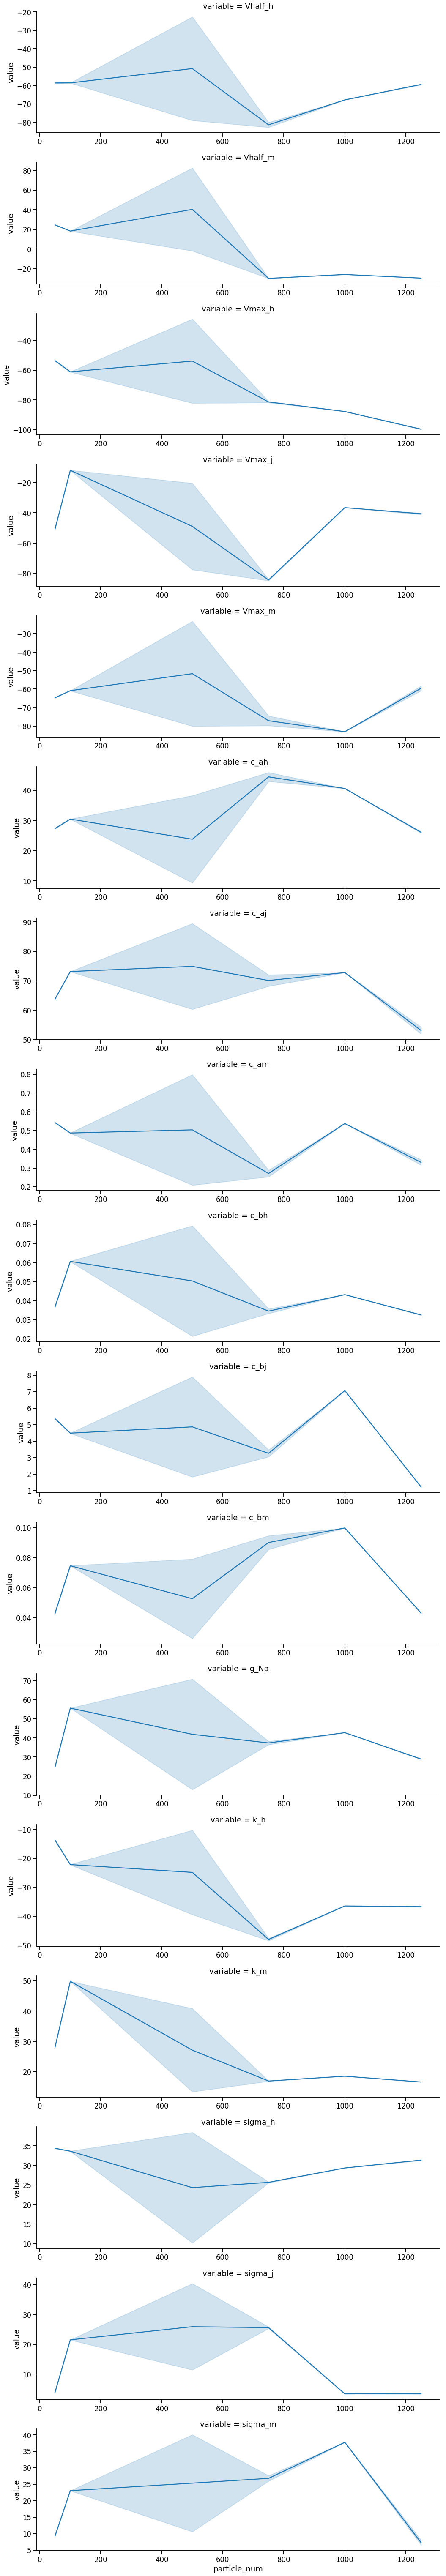

In [29]:
sns.set_context('talk')
grid = sns.relplot(x='particle_num',y='value',row='variable',data=th_samples,
                   kind='line',n_boot=5000,ci='sd',aspect=3,
                   facet_kws={'sharex': 'row',
                   'sharey': False})